In [2]:
import requests
import xarray as xr
from multiprocessing import cpu_count
from multiprocessing.pool import ThreadPool
import os
from pathlib import Path
import time
import json
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

## Step 1: Go to the web portal
Got to the its_live web app [data portal](https://nsidc.org/apps/itslive/). For Greenland, I like to change the projection to Polar Stereographic North (epsg:3413). To do this, toggle the 'N' button on the left side of the webpage on. Also we will be downloading image-pair velocities, so make sure you select 'Data Access: Image Pair Velocity Selection' under the 'Toggle Data' button on the left side of the webpage

Your webpage should look like this (*note the toggled 'N' on the left hand side):
![web portal image](images/web_portal_3413.png) 

## Step 2: Make your region of interest
Next, draw a polygon over your region of interest. For this tutorial, let's make our roi over Store Glacier. To draw a polygon click the pencil icon under the 'S' on the left hand side of the website.

My polygon looks like this ![polygon image](images/polygon.png) 



## Step 3: Download the data
Now click in the interior of the polygon. This will bring up a pop up where you can filter what image-pair velocities to download. For the sake of storage, let's make this smaller and filter only image pairs less than 7 days apart in 2022, and with 90% overlap of the polygon. Also make sure to set the output as a JSON. Next click the 'Get Granule URLs' and set your path to where the json file will be downloaded.

My pop up looks like this

![polygon image](images/filter_images.png) 


## Step 4: Unzip json and download urls
Unzip your download and place it somewhere easy to access. I took my json file out of the directory and renamted it 'store_its_live_velocities_2022.json'. The json file contains the urls you can use to download the images. We can use a combination of the json, requests, and multiprocessing libraries to download the urls in parallel. The cell below will donwload the velocity data from the json file.



In [3]:
output_path = 'image_pair_velocities/'
Path(output_path).mkdir(parents=True, exist_ok=True)

# I just unzipped and saved the json file in the main directory here
its_live_json = 'store_its_live_velocities_2022.json'

json_open = open(its_live_json)

velocity_pairs_json = json.load(json_open)

url_fn_pairs = []
for json_vel in velocity_pairs_json:
    url = json_vel['url']
    
    fn = os.path.split(url)[1]
    fn = f'{output_path}{fn}'
    
    url_fn_pairs.append((url,fn))
    

def download_url(args):
    t0 = time.time()
    url, fn = args[0], args[1]
    try:
        r = requests.get(url)
        with open(fn, 'wb') as f:
            f.write(r.content)
        return(url, time.time() - t0)
    except Exception as e:
        print('Exception in download_url():', e)
        
        
def download_parallel(args):
    cpus = cpu_count()
    results = ThreadPool(cpus - 1).imap_unordered(download_url, args)
    for result in results:
        print('url:', result[0], 'time (s):', result[1])
        
        
download_parallel(url_fn_pairs)
json_open.close()

url: https://its-live-data.s3.amazonaws.com/velocity_image_pair/sentinel2-latest/N70W040/S2A_MSIL1C_20220514T152811_N0400_R111_T22WED_20220514T191747_X_S2B_MSIL1C_20220519T152809_N0400_R111_T22WED_20220519T202554_G0120V02_P099.nc time (s): 0.8573760986328125
url: https://its-live-data.s3.amazonaws.com/velocity_image_pair/sentinel2-latest/N70W040/S2A_MSIL1C_20220328T153841_N0400_R011_T22WED_20220328T192534_X_S2B_MSIL1C_20220402T153809_N0400_R011_T22WED_20220402T174110_G0120V02_P099.nc time (s): 0.8656458854675293
url: https://its-live-data.s3.amazonaws.com/velocity_image_pair/sentinel2-latest/N70W040/S2A_MSIL1C_20220501T151811_N0400_R068_T22WED_20220501T185805_X_S2B_MSIL1C_20220506T151759_N0400_R068_T22WED_20220506T172714_G0120V02_P099.nc time (s): 0.9561398029327393
url: https://its-live-data.s3.amazonaws.com/velocity_image_pair/sentinel2-latest/N70W040/S2B_MSIL1C_20220323T153809_N0400_R011_T22WED_20220323T193502_X_S2A_MSIL1C_20220328T153841_N0400_R011_T22WED_20220328T192534_G0120V02_P

## We did it!! We successfully downloaded image pairs. Now Let's use them 

# Part 2: Simple use of image-pair velocities 

In [3]:
#data = xr.open_dataset('image_pair_velocities/S2A_MSIL1C_20220318T154001_N0400_R011_T22WED_20220318T193242_X_S2B_MSIL1C_20220323T153809_N0400_R011_T22WED_20220323T193502_G0120V02_P097.nc')
# here we will sort the list by the date of the first image pair
nc_list = sorted([nc for nc in os.listdir('image_pair_velocities') if nc.endswith('.nc')],
                key = lambda x: gpd.pd.to_datetime(x[11:26].replace('T',' ')))
nc_read_list = [xr.open_dataset(f'image_pair_velocities/{nc}') for nc in nc_list]
nc_read_list = [nc_read_list[var].expand_dims('time') for var in range(len(nc_read_list))]

In [5]:
time_list = [gpd.pd.to_datetime(dt[11:26].replace('T',' ')) for dt in nc_list]
nc_read_list = [nc_read_list[var].assign_coords(time=[time_list[var]]) for var in range(len(nc_read_list))]

da_v_ls = [ds['v'] for ds in nc_read_list]
da_vx_ls = [ds['vx'] for ds in nc_read_list]
da_vy_ls = [ds['vy'] for ds in nc_read_list]
v_concat = xr.concat(da_v_ls, dim='time')
vx_concat = xr.concat(da_vx_ls, dim='time')
vy_concat = xr.concat(da_vy_ls, dim='time')

ds_merge = xr.merge([v_concat, vx_concat, vy_concat])

In [6]:
pt_path = 'geoms/sample_points.shp'
pt_df = gpd.read_file(pt_path)
xy = pt_df.geometry.bounds[pt_df.geometry.bounds.columns[:2]].rename(columns={'minx':'x','miny':'y'})

<Axes: title={'center': 'time = 2022-03-18T15:40:01'}, xlabel='projection_x_coordinate [m]', ylabel='projection_y_coordinate [m]'>

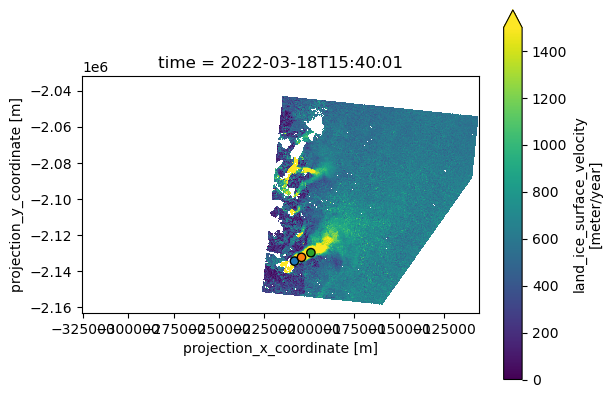

In [7]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig, ax = plt.subplots()
ds_merge.v.isel(time=0).plot(ax=ax,vmax=1500,)
pt_df.plot(ax=ax,c=colors,linewidth=1,edgecolor='black')

Text(0, 0.5, 'm yr$^{-1}$')

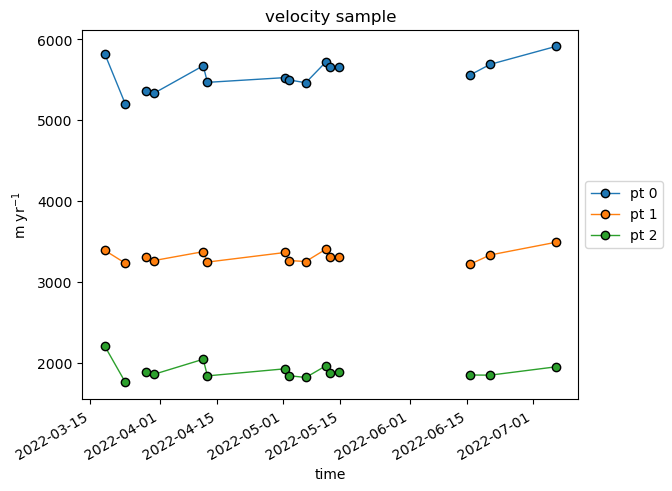

In [8]:
for index,row in xy.iterrows():
    x,y = row['x'], row['y']
    vel_sample = ds_merge.sel(x=x,y=y,method='nearest')
    vel_plot = vel_sample.v.plot.line('-o',label=f'pt {index}',x='time', add_legend=True,
                                       linewidth=1,markeredgecolor='k')
plt.title('velocity sample')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('m yr$^{-1}$')

## Remarks
This is just a way to use netcdf velocties with xarray. its_live has online point sample tools that are amazing and should be used a lot. Though if you download the data offline and want to sample velocity, this is how I do it. 